<a href="https://colab.research.google.com/github/MikhailGalperin/MyFirstRep/blob/main/%22%D0%91%D0%BE%D0%BB%D1%8C%D1%88%D0%BE%D0%B5_%D0%94%D0%97_2_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://colab.research.google.com/drive/1rEsz71krYajutylPbFSvngpAWZisroqT#scrollTo=OrccWeKaU1Nh

<h2 style="text-align: center;"><b>Большое домашнее задание 2. Участие в соревнованиях на Kaggle. Работа с нерепрезентативными данными.
</b></h2>

ДЗ в колабе: https://colab.research.google.com/drive/18Hi97eESCrXYht-7SIoj_19pwcZhl17Y?usp=sharing

В этом домашнем задании нам нужно применить в реальном соревновании накопленные знания по машинному обучению и анализу данных!

- Нужно будет провести предобработку [данных с Kaggle](https://www.kaggle.com/sid321axn/thoraric-surgery). Затем нужно будет предсказать колонку DGN (диагноз). Это задача классификации. 
- Описание датасета (что значит признаки): https://archive.ics.uci.edu/ml/datasets/Thoracic+Surgery+Data 
- Не забудьте провести анализ данных перед тем, как применять ML-модели! Вам нужно сначала понять, с чем Вы имеете дело, поискать зависимости в данных, понять природу этих зависимостей, и только после этого уже подбирать алгоритмы. Данные с подвохом! Внимательно смотрите на распределения признаков в каждом из классов!
- В качестве основы можно использовать наработки с занятий. Необходимо попробовать сделать аугментацию данных, т.к. данных очень мало, для обучения содержательных моделей их не хватит.
- Попробуйте kNN, логистическую регрессию, SVM. Поэкспериментируйте с добавлением композитных признаков (например, полиномиальных), выбором ядра (для SVM). Подберите гиперпараметры по кросс-валидации (GridSearchCV или RandomSearchCV, второй вариант предпочтительнее).  
- Достичь идеального качества Вам не удастся, да и гнаться за этим не стоит. Гораздо важнее провести вдумчивый анализ и показать, что Вы разобрались в теме.

**Правила:**

- **Дедлайн один:** 29 января 23:59. Решения, отправленные позже, проверяться не будут, кроме случаев наличия уважительной причины.



Решения, размещенные на каких-либо интернет-ресурсах, не принимаются.
 При написании кода придерживайтесь `pep8` и используйте `type hints`.

**После жесткого дедлайна задания не принимаются. Так как дальше будет работа только над проектом**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve
from sklearn.pipeline import Pipeline

In [ ]:
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file «{name}» with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

Saving ThoraricSurgery.csv to ThoraricSurgery (1).csv
User uploaded file «ThoraricSurgery.csv» with length 25585 bytes


In [ ]:
#df = open('ThoraricSurgery.csv')
df = pd.read_csv('ThoraricSurgery.csv')

1. DGN: диагностика - специфическая комбинация кодов МКБ-10 для первичных и вторичных, а также множественных опухолей, если таковые имеются (DGN3, DGN2, DGN4, DGN6, DGN5, DGN8, DGN1)
2. PRE4: Форсированная жизненная емкость легких - FVC (числовой)
3. PRE5: Объем выдоха в конце первой секунды принудительного выдоха - FEV1 (числовой).
4. PRE6: Состояние производительности - шкала Зуброда (PRZ2, PRZ1, PRZ0)
5. PRE7: Боль перед операцией (T, F)
6. PRE8: Кровохарканье перед операцией (T, F)
7. PRE9: Одышка перед операцией (T, F)
8. PRE10: кашель перед операцией (T, F)
9. PRE11: Слабость перед операцией (T, F)
10. PRE14: T в клиническом TNM - размер исходной опухоли от ОС11 (наименьшая) до ОС14 (наибольшая) (ОС11, ОС14, ОС12, ОС13).
11. PRE17: СД 2 типа - сахарный диабет (T, F)
12. PRE19: ИМ до 6 месяцев (T, F)
13. PRE25: PAD - заболевания периферических артерий (T, F)
14. PRE30: Курение (T, F)
15. PRE32: Астма (T, F)
16. ВОЗРАСТ: возраст на момент операции (числовой).
17. Risk1Y: 1 год выживания - (T) значение рут в случае смерти (T, F)

In [ ]:
#просмотр данных
#названия бинарных признаков оставляем, численных и категориальных делаем понятными
df.rename(columns={'PRE4': 'LungCap', 'PRE5': 'ExhVol', 'PRE6': 'PRFRM', 'PRE14': 'SIZE'}, inplace=True)
df.head(5)

,id,DGN,LungCap,ExhVol,PRFRM,PRE7,PRE8,PRE9,PRE10,PRE11,SIZE,PRE17,PRE19,PRE25,PRE30,PRE32,AGE,Risk1Yr
0,1,DGN2,2.88,2.16,PRZ1,F,F,F,T,T,OC14,F,F,F,T,F,60,F
1,2,DGN3,3.40,1.88,PRZ0,F,F,F,F,F,OC12,F,F,F,T,F,51,F
2,3,DGN3,2.76,2.08,PRZ1,F,F,F,T,F,OC11,F,F,F,T,F,59,F
3,4,DGN3,3.68,3.04,PRZ0,F,F,F,F,F,OC11,F,F,F,F,F,54,F
4,5,DGN3,2.44,0.96,PRZ2,F,T,F,T,T,OC11,F,F,F,T,F,73,T


In [ ]:
#целостность и типы
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 470 entries, 0 to 469
Data columns (total 18 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       470 non-null    int64  
 1   DGN      470 non-null    object 
 2   LungCap  470 non-null    float64
 3   ExhVol   470 non-null    float64
 4   PRFRM    470 non-null    object 
 5   PRE7     470 non-null    object 
 6   PRE8     470 non-null    object 
 7   PRE9     470 non-null    object 
 8   PRE10    470 non-null    object 
 9   PRE11    470 non-null    object 
 10  SIZE     470 non-null    object 
 11  PRE17    470 non-null    object 
 12  PRE19    470 non-null    object 
 13  PRE25    470 non-null    object 
 14  PRE30    470 non-null    object 
 15  PRE32    470 non-null    object 
 16  AGE      470 non-null    int64  
 17  Risk1Yr  470 non-null    object 
dtypes: float64(2), int64(2), object(14)
memory usage: 66.2+ KB


In [ ]:
#переводим категориальные признаки в числовые
from sklearn import preprocessing

def number_encode_features(init_df):
    result = init_df.copy()
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object:
            encoders[column] = preprocessing.LabelEncoder()
            result[column] = encoders[column].fit_transform(result[column])
    return result, encoders

df2, encoders = number_encode_features(df)
df2.head()

,id,DGN,LungCap,ExhVol,PRFRM,PRE7,PRE8,PRE9,PRE10,PRE11,SIZE,PRE17,PRE19,PRE25,PRE30,PRE32,AGE,Risk1Yr
0,1,1,2.88,2.16,1,0,0,0,1,1,3,0,0,0,1,0,60,0
1,2,2,3.40,1.88,0,0,0,0,0,0,1,0,0,0,1,0,51,0
2,3,2,2.76,2.08,1,0,0,0,1,0,0,0,0,0,1,0,59,0
3,4,2,3.68,3.04,0,0,0,0,0,0,0,0,0,0,0,0,54,0
4,5,2,2.44,0.96,2,0,1,0,1,1,0,0,0,0,1,0,73,1


In [ ]:
#описание данных
df2.describe()

,id,DGN,LungCap,ExhVol,PRFRM,PRE7,PRE8,PRE9,PRE10,PRE11,SIZE,PRE17,PRE19,PRE25,PRE30,PRE32,AGE,Risk1Yr
count,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000,470.000000
mean,235.500000,2.091489,3.281638,4.568702,0.780851,0.065957,0.144681,0.065957,0.687234,0.165957,0.736170,0.074468,0.004255,0.017021,0.821277,0.004255,62.534043,0.148936
std,135.821574,0.695808,0.871395,11.767857,0.535375,0.248472,0.352154,0.248472,0.464114,0.372439,0.702243,0.262811,0.065163,0.129488,0.383529,0.065163,8.706902,0.356405
min,1.000000,0.000000,1.440000,0.960000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.000000,0.000000
25%,118.250000,2.000000,2.600000,1.960000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,57.000000,0.000000
50%,235.500000,2.000000,3.160000,2.400000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,62.000000,0.000000
75%,352.750000,2.000000,3.807500,3.080000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,69.000000,0.000000
max,470.000000,6.000000,6.300000,86.300000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,87.000000,1.000000


DGN0 -- 1 -- 0.21 %
DGN1 -- 52 -- 11.06 %
DGN2 -- 349 -- 74.26 %
DGN3 -- 47 -- 10.0 %
DGN4 -- 15 -- 3.19 %
DGN5 -- 4 -- 0.8500000000000001 %
DGN6 -- 2 -- 0.43 %


<BarContainer object of 7 artists>

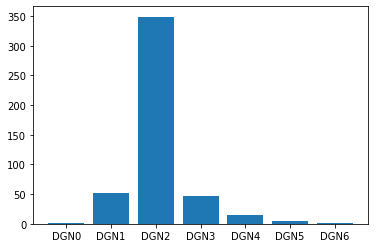

In [ ]:
# Распределение диагнозов. Сбалансированность.
def calculation(x):
    return (df2['DGN'] == x).sum()

print('DGN0', '--', calculation(0), '--', round(calculation(0) / df['DGN'].count(), 4) * 100, '%')
print('DGN1', '--', calculation(1), '--', round(calculation(1) / df['DGN'].count(), 4) * 100, '%')
print('DGN2', '--', calculation(2), '--', round(calculation(2) / df['DGN'].count(), 4) * 100, '%')
print('DGN3', '--', calculation(3), '--', round(calculation(3) / df['DGN'].count(), 4) * 100, '%')
print('DGN4', '--', calculation(4), '--', round(calculation(4) / df['DGN'].count(), 4) * 100, '%')
print('DGN5', '--', calculation(5), '--', round(calculation(5) / df['DGN'].count(), 4) * 100, '%')
print('DGN6', '--', calculation(6), '--', round(calculation(6) / df['DGN'].count(), 4) * 100, '%')

groups = ['DGN0', 'DGN1', 'DGN2', 'DGN3', 'DGN4', 'DGN5', 'DGN6']
counts = [calculation(0), calculation(1), calculation(2), calculation(3), calculation(4), calculation(5), calculation(6)]
plt.bar(groups, counts)

In [ ]:
# Пробуем расширить выборку, добавив данные в самые малочисленные классы (диагнозы 0, 5, 6), уравняв их по численности с классом диагноз 4.
# В противном случае алгоритмы обучения корректно работать не будут.
# Для этого создаём temp_df

temp_df = df2[df2['DGN'].isin(['0', '5', '6'])]
temp_df.sort_values('DGN', ascending = True)

,id,DGN,LungCap,ExhVol,PRFRM,PRE7,PRE8,PRE9,PRE10,PRE11,SIZE,PRE17,PRE19,PRE25,PRE30,PRE32,AGE,Risk1Yr
292,293,0,3.80,2.80,0,0,0,0,0,0,1,0,0,0,1,0,62,0
29,30,5,3.96,3.28,0,0,0,0,0,0,0,0,0,0,1,0,61,0
97,98,5,3.04,2.40,2,0,0,0,1,0,0,0,0,0,1,0,76,0
368,369,5,3.88,2.72,1,0,0,0,1,0,1,0,0,0,1,0,77,0
405,406,5,5.36,3.96,1,0,0,0,1,0,1,0,0,0,0,0,62,0
24,25,6,4.32,3.20,0,0,0,0,0,0,0,0,0,0,0,0,58,1
446,447,6,5.20,4.10,0,0,0,0,0,0,1,0,0,0,0,0,49,0


In [ ]:
temp_df_0 = df2[df2['DGN'].isin(['0'])]
temp_df_0

,id,DGN,LungCap,ExhVol,PRFRM,PRE7,PRE8,PRE9,PRE10,PRE11,SIZE,PRE17,PRE19,PRE25,PRE30,PRE32,AGE,Risk1Yr
292,293,0,3.8,2.8,0,0,0,0,0,0,1,0,0,0,1,0,62,0


In [ ]:
temp_df = pd.concat([temp_df, temp_df_0], ignore_index=True)
temp_df.sort_values('DGN', ascending = True)

,id,DGN,LungCap,ExhVol,PRFRM,PRE7,PRE8,PRE9,PRE10,PRE11,SIZE,PRE17,PRE19,PRE25,PRE30,PRE32,AGE,Risk1Yr
3,293,0,3.80,2.80,0,0,0,0,0,0,1,0,0,0,1,0,62,0
7,293,0,3.80,2.80,0,0,0,0,0,0,1,0,0,0,1,0,62,0
1,30,5,3.96,3.28,0,0,0,0,0,0,0,0,0,0,1,0,61,0
2,98,5,3.04,2.40,2,0,0,0,1,0,0,0,0,0,1,0,76,0
4,369,5,3.88,2.72,1,0,0,0,1,0,1,0,0,0,1,0,77,0
5,406,5,5.36,3.96,1,0,0,0,1,0,1,0,0,0,0,0,62,0
0,25,6,4.32,3.20,0,0,0,0,0,0,0,0,0,0,0,0,58,1
6,447,6,5.20,4.10,0,0,0,0,0,0,1,0,0,0,0,0,49,0


In [ ]:
temp_df_06 = temp_df[temp_df['DGN'].isin(['0', '6'])]
temp_df_06.sort_values('DGN', ascending = True)

,id,DGN,LungCap,ExhVol,PRFRM,PRE7,PRE8,PRE9,PRE10,PRE11,SIZE,PRE17,PRE19,PRE25,PRE30,PRE32,AGE,Risk1Yr
3,293,0,3.80,2.8,0,0,0,0,0,0,1,0,0,0,1,0,62,0
7,293,0,3.80,2.8,0,0,0,0,0,0,1,0,0,0,1,0,62,0
0,25,6,4.32,3.2,0,0,0,0,0,0,0,0,0,0,0,0,58,1
6,447,6,5.20,4.1,0,0,0,0,0,0,1,0,0,0,0,0,49,0


In [ ]:
temp_df = pd.concat([temp_df, temp_df_06], ignore_index=True)
temp_df.sort_values('DGN', ascending = True)

,id,DGN,LungCap,ExhVol,PRFRM,PRE7,PRE8,PRE9,PRE10,PRE11,SIZE,PRE17,PRE19,PRE25,PRE30,PRE32,AGE,Risk1Yr
3,293,0,3.80,2.80,0,0,0,0,0,0,1,0,0,0,1,0,62,0
7,293,0,3.80,2.80,0,0,0,0,0,0,1,0,0,0,1,0,62,0
9,293,0,3.80,2.80,0,0,0,0,0,0,1,0,0,0,1,0,62,0
11,293,0,3.80,2.80,0,0,0,0,0,0,1,0,0,0,1,0,62,0
1,30,5,3.96,3.28,0,0,0,0,0,0,0,0,0,0,1,0,61,0
2,98,5,3.04,2.40,2,0,0,0,1,0,0,0,0,0,1,0,76,0
4,369,5,3.88,2.72,1,0,0,0,1,0,1,0,0,0,1,0,77,0
5,406,5,5.36,3.96,1,0,0,0,1,0,1,0,0,0,0,0,62,0
0,25,6,4.32,3.20,0,0,0,0,0,0,0,0,0,0,0,0,58,1
6,447,6,5.20,4.10,0,0,0,0,0,0,1,0,0,0,0,0,49,0


In [ ]:
i = 1
for i in range(2):
  temp_df = pd.concat([temp_df, temp_df], ignore_index=True)
  i += 1

temp_df.sort_values('DGN', ascending = True)

,id,DGN,LungCap,ExhVol,PRFRM,PRE7,PRE8,PRE9,PRE10,PRE11,SIZE,PRE17,PRE19,PRE25,PRE30,PRE32,AGE,Risk1Yr
23,293,0,3.80,2.80,0,0,0,0,0,0,1,0,0,0,1,0,62,0
45,293,0,3.80,2.80,0,0,0,0,0,0,1,0,0,0,1,0,62,0
43,293,0,3.80,2.80,0,0,0,0,0,0,1,0,0,0,1,0,62,0
39,293,0,3.80,2.80,0,0,0,0,0,0,1,0,0,0,1,0,62,0
35,293,0,3.80,2.80,0,0,0,0,0,0,1,0,0,0,1,0,62,0
33,293,0,3.80,2.80,0,0,0,0,0,0,1,0,0,0,1,0,62,0
31,293,0,3.80,2.80,0,0,0,0,0,0,1,0,0,0,1,0,62,0
27,293,0,3.80,2.80,0,0,0,0,0,0,1,0,0,0,1,0,62,0
21,293,0,3.80,2.80,0,0,0,0,0,0,1,0,0,0,1,0,62,0
19,293,0,3.80,2.80,0,0,0,0,0,0,1,0,0,0,1,0,62,0


In [ ]:
# Чтобы включить в датафрейм добавляемые данные (temp_df), доводящие численность классов диагнозов 0, 5, 6 до численности диагноза 4, здесь решётки нужно снять
# df3 = pd.concat([df2, temp_df], ignore_index=True)

# В базовом варианте оставляем данные в исходном виде
df3 = df2

# Исключаем столбец "Id", не несущий полезной информации
df3 = df3.drop('id', axis = 1)

# Исключаем столбец "Risk 1 Year -- Риск смерти в течение года". Если я правильно понял задачу, то в этом столбце содержится информация о смерти в течение года после операции,
# она имеет значение для статистики, но в постановке диагноза не участвует
df3 = df3.drop('Risk1Yr', axis = 1)
df3.head()

,DGN,LungCap,ExhVol,PRFRM,PRE7,PRE8,PRE9,PRE10,PRE11,SIZE,PRE17,PRE19,PRE25,PRE30,PRE32,AGE
0,1,2.88,2.16,1,0,0,0,1,1,3,0,0,0,1,0,60
1,2,3.40,1.88,0,0,0,0,0,0,1,0,0,0,1,0,51
2,2,2.76,2.08,1,0,0,0,1,0,0,0,0,0,1,0,59
3,2,3.68,3.04,0,0,0,0,0,0,0,0,0,0,0,0,54
4,2,2.44,0.96,2,0,1,0,1,1,0,0,0,0,1,0,73


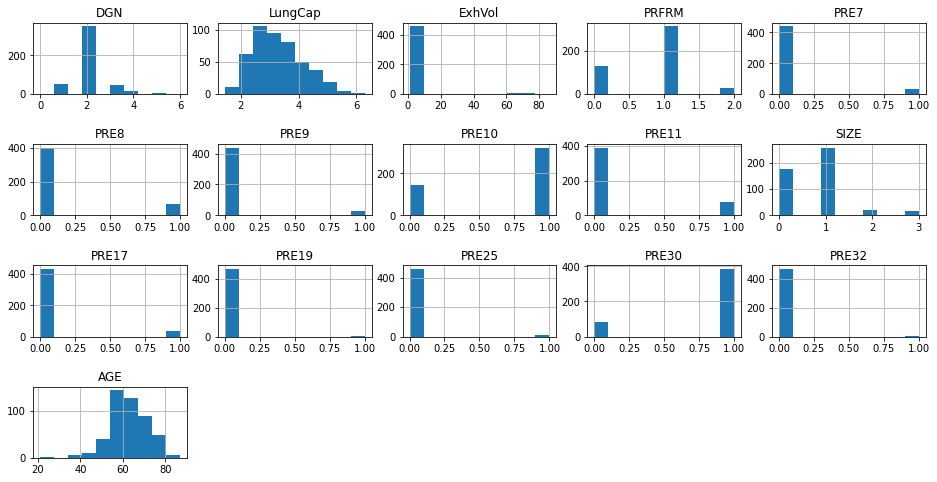

In [ ]:
# Распределение величин
fig = plt.figure(figsize=(16,8))
cols = 5

rows = np.ceil(float(df3.shape[1]) / cols)
for i, column in enumerate(df3.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    df3[column].hist(axes=ax)
plt.subplots_adjust(hspace=0.7, wspace=0.2)

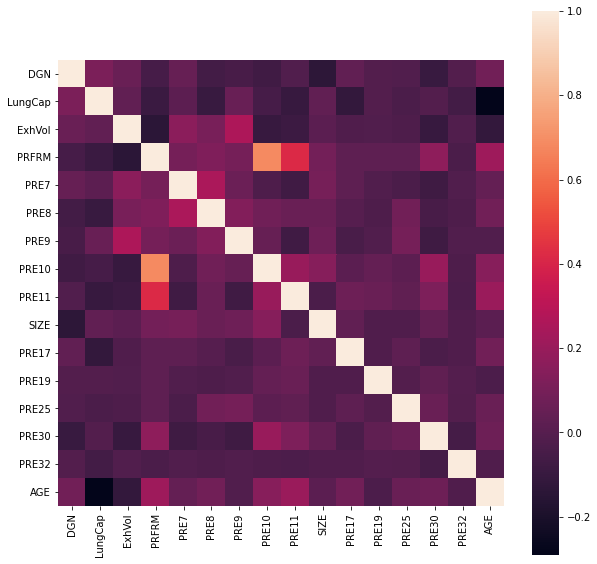

In [ ]:
# Матрица корреляций
plt.subplots(figsize=(10,10))
df3, encoders = number_encode_features(df3)
sns.heatmap(df3.corr(), square=True)
plt.show()

In [ ]:
# По результатам изучения матрицы корреляций исключаем столбец "Performance -- прозводительность" как имеющий корреляцию со столбцами "PRE10 -- кашель" и "PRE11 -- слабость"
# Остальные столбцы не демонстрируют заметной корреляции между собой
df3 = df3.drop('PRFRM', axis = 1)
df3.head()

,DGN,LungCap,ExhVol,PRE7,PRE8,PRE9,PRE10,PRE11,SIZE,PRE17,PRE19,PRE25,PRE30,PRE32,AGE
0,1,2.88,2.16,0,0,0,1,1,3,0,0,0,1,0,60
1,2,3.40,1.88,0,0,0,0,0,1,0,0,0,1,0,51
2,2,2.76,2.08,0,0,0,1,0,0,0,0,0,1,0,59
3,2,3.68,3.04,0,0,0,0,0,0,0,0,0,0,0,54
4,2,2.44,0.96,0,1,0,1,1,0,0,0,0,1,0,73


In [ ]:
# перемешка
df3 = df3.sample(frac=1).reset_index(drop=True)
# создание выборки
X = df3.drop(columns=['DGN']).values
y = df3['DGN'].values
# нормализация
X_scaled = scale(np.array(X, dtype='float'), with_std=True, with_mean=True)
X = X_scaled
#y_scaled = scale(np.array(y, dtype='float'), with_std=True, with_mean=True)
#y = y_scaled
# разделение на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

# получившиеся выборки
print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

X_train (376, 14)
y_train (376,)
X_test (94, 14)
y_test (94,)


In [ ]:
# полиномиальные признаки
def create_polinomial(X, degree):
  return PolynomialFeatures(degree).fit_transform(X)
X_train = create_polinomial(X_train, 2)
X_test = create_polinomial(X_test, 2)

# получившиеся выборки
print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

X_train (376, 120)
y_train (376,)
X_test (94, 120)
y_test (94,)


In [ ]:
# Аугментация
def oversample_data(X, y):
  return AdaSyn(sampling_strategy = 'minority').fit_resample(np.array(X), np.array(y))
def undersample_data(X, y):
  return TomekLinks().fit_resample(np.array(X), np.array(y))
def augment_data(X, y):
  try:
    X, y = oversample_data(X, y)
  except:
    pass
  #try:
  #  X, y = undersample_data(X, y)
  #except:
  #  pass
  return X, y

X_train, y_train = augment_data(X_train, y_train)

# получившиеся выборки
print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

X_train (376, 120)
y_train (376,)
X_test (94, 120)
y_test (94,)


In [ ]:
# SVM

alg = SVC()

grid = {'C': np.array(np.linspace(0, 100, 100), dtype = 'float'),
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        }

gs = GridSearchCV(alg, grid, verbose = 2, n_jobs = -1, scoring = 'f1_weighted')
gs.fit(X_train, y_train)
gs.best_params_, gs.best_score_

Fitting 5 folds for each of 400 candidates, totalling 2000 fits


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 519 tasks      | elapsed:   43.4s
[Parallel(n_jobs=-1)]: Done 870 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 1769 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 1997 out of 2000 | elapsed:  5.8min remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:  5.8min finished


({'C': 15.151515151515152, 'kernel': 'rbf'}, 0.6635051211662599)

In [ ]:
alg = SVC(C =  15.15, kernel = 'rbf')
alg.fit(X_train, y_train)
preds = alg.predict(X_test)
print(metrics.classification_report(y_test, preds))

              precision    recall  f1-score   support

           1       0.25      0.08      0.12        13
           2       0.69      0.94      0.79        65
           3       0.00      0.00      0.00        11
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00         2

    accuracy                           0.66        94
   macro avg       0.19      0.20      0.18        94
weighted avg       0.51      0.66      0.56        94



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Логистическая регрессия

alg = LogisticRegression(class_weight = 'balanced')

grid = {'penalty': ['l1', 'l2', 'elasticnet'],
        'C': np.array(np.linspace(0, 100, 200), dtype='float')}

gs = GridSearchCV(alg, grid, verbose=2, n_jobs = -1)
gs.fit(X_train, y_train)
gs.best_params_, gs.best_score_

Fitting 5 folds for each of 600 candidates, totalling 3000 fits


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 228 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 1196 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done 2820 tasks      | elapsed:   52.4s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   55.6s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_m

({'C': 30.15075376884422, 'penalty': 'l2'}, 0.4654035087719298)

In [ ]:
# получили предупреждение о несходимости
# пытаемся применить StandartScaler

scaler = StandardScaler().fit(X_train)
X_scaled = scaler.transform(X_train)
gs.fit(X_scaled, y_train)
gs.best_params_, gs.best_score_

Fitting 5 folds for each of 600 candidates, totalling 3000 fits


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 228 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 1196 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done 2820 tasks      | elapsed:   51.8s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:   55.0s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_m

({'C': 84.92462311557789, 'penalty': 'l2'}, 0.4308070175438596)

In [ ]:
# со StandartScaler результаты ухудшились, а проблема не решилась
# пробуем 10 фолдов
# учится 10 минут, результат тот же

gs = GridSearchCV(alg, grid, verbose=2, n_jobs = -1, cv = 10)
gs.fit(X_train, y_train)
gs.best_params_, gs.best_score_

Fitting 10 folds for each of 600 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 610 tasks      | elapsed:   43.6s
[Parallel(n_jobs=-1)]: Done 1206 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1906 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 2672 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 3862 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 5156 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:  9.5min finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

({'C': 97.98994974874371, 'penalty': 'l2'}, 0.4903019744483158)

In [ ]:
# увеличиваем число итераций в регрессии
# учится 7.5 минут; результат тот же

alg = LogisticRegression(class_weight = 'balanced', max_iter = 1000)

grid = {'penalty': ['l1', 'l2', 'elasticnet'],
        'C': np.array(np.linspace(0, 100, 200), dtype='float')}

gs = GridSearchCV(alg, grid, verbose=2, n_jobs = -1)
gs.fit(X_train, y_train)
gs.best_params_, gs.best_score_

Fitting 5 folds for each of 600 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 438 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done 844 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1410 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 2132 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 2997 out of 3000 | elapsed:  7.6min remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  7.6min finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

({'C': 78.89447236180904, 'penalty': 'l2'}, 0.49785483397002644)

In [ ]:
# Метрики

alg = LogisticRegression(penalty = 'l2', C = 30.15)
alg.fit(X_train, y_train)
preds = alg.predict(X_test)
print(metrics.classification_report(y_test, preds))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        13
           2       0.69      0.94      0.80        65
           3       0.00      0.00      0.00        11
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         0

    accuracy                           0.65        94
   macro avg       0.12      0.16      0.13        94
weighted avg       0.48      0.65      0.55        94



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in

In [ ]:
# knn

knn = KNeighborsClassifier()
grid = {'n_neighbors': np.array(np.linspace(1, 100, 100), dtype = 'int')}
gs = GridSearchCV(knn, grid, cv = 5)
gs.fit(X_train, y_train)
gs.best_params_, gs.best_score_

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


({'n_neighbors': 9}, 0.7260350877192983)

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 9) 
clf_knn = knn.fit(X_train, y_train)
y_knn = clf_knn.predict(X_test)

# Метрики
print(metrics.classification_report(y_test, y_knn))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         6
           2       0.82      0.96      0.89        78
           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00         3

    accuracy                           0.80        94
   macro avg       0.16      0.19      0.18        94
weighted avg       0.68      0.80      0.74        94



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


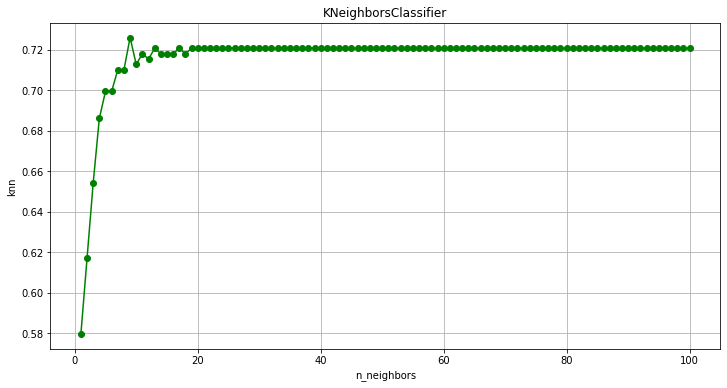

In [ ]:
def grid_plot(x, y, x_label, title, y_label='knn'):
    plt.figure(figsize=(12, 6))
    plt.grid(True)
    plt.plot(x, y, 'go-')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

grid_plot(grid['n_neighbors'], gs.cv_results_['mean_test_score'], 'n_neighbors', 'KNeighborsClassifier')

In [ ]:
# Кривые обучения

def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, '-', **kwargs)
    plt.fill_between(x, mu - std, mu + std, edgecolor='none', facecolor = lines[0].get_color(), alpha = 0.2)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


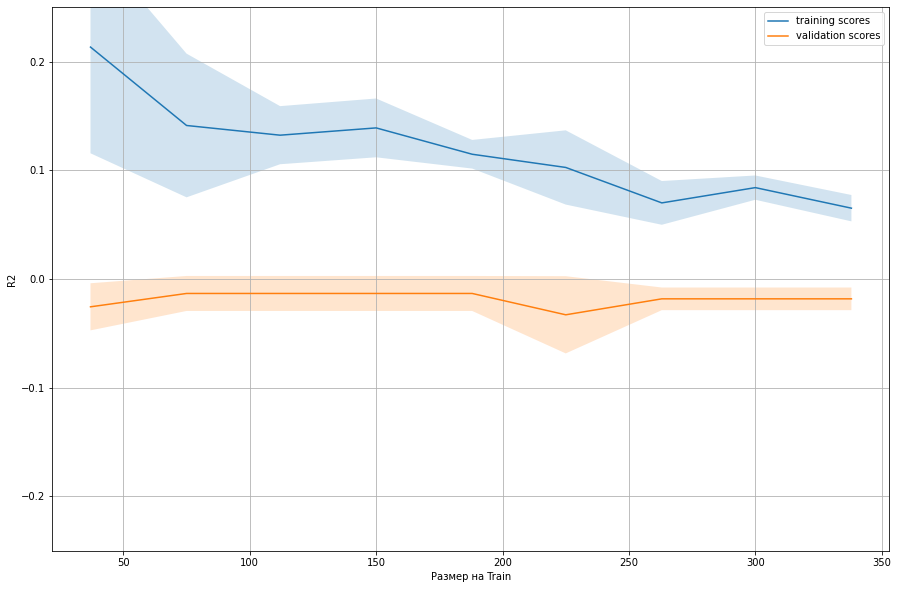

In [ ]:
pipe = Pipeline([('scaler', preprocessing.StandardScaler()),
                 ('poly', PolynomialFeatures(degree=2)),
                 ('alg', SVC())])

N_train, val_train, val_test = learning_curve(pipe,
                                              df3.drop(columns = ['DGN']).values,
                                              df3['DGN'].values,
                                              train_sizes = np.linspace(0.1, 0.9, 9),
                                              cv = 5,
                                              scoring = 'r2')
from matplotlib.pyplot import figure, ylim
figure(figsize = (15, 10))
plt.grid()
ylim(-0.25, 0.25)
plot_with_err(N_train, val_train, label = 'training scores')
plot_with_err(N_train, val_test, label = 'validation scores')
plt.xlabel('Размер на Train')
plt.ylabel('R2')
plt.legend()

Характер кривых говорит о недостаточности данных